# Data Cleaning
This notebook includes analysis with regards to the data cleaning step that is taken for the earthquake damage dataset.

In [1]:
# enables referencing modules in repository
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat

from scipy.stats import chi2_contingency

from src.features import build_features
# from src.data import make_dataset 
# commented out because: there seems to be an issue at the moment with the initial method from make_dataset
from src.models import train_model
from src.models import predict_model
from src.visualization import visualize
from tabulate import tabulate
from scipy import stats

In [2]:
# Loading the data
train_df = pd.read_csv('../data/raw/train_values.csv')

## Determining the type of features
---
From the exploratory data analysis the following descriptions of the features have been derived:

1. `building_id` seems to be used to identify each unique building.
2. `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` these features seem to describe the location the building is located in.
3. `count_floors_pre_eq` seems to be the number of floors the building had before the earthquake happend
4. `age` seems to be the age of the building before it was destroyed
5. `area_percentage` maybe the amount of buildings in an area 
6. `height_percentage` likely the height of the building before it was destroyed
7. `land_surface_condition` likely the condition the surface of the ground of the building had before the earthquake
8. `foundation_type` as the name suggests this seems to be the type of the foundation the building was built 
9. `roof_type`, `ground_floor_type`, `other_floor_type` as the name suggest this seems to be the type of the roof and floors the building had. It seems like only to types of floors where recorded
10. `position` (unkown)
11. `plan_configuration` likely class of building structure
12. `has_superstructure..` likely a one hot encoded feature that represents the type of used superstructure
13. `legal_ownership_status` likely who the building belongs to
14. `count_families` seems to be the amount of families that lived in the building
15. `has_secondary_use..` seems to describe whether the building had an additional purpose than living in it

In [3]:
# get the data types as a string
dtypes_str = train_df.dtypes.to_string()

# print the data types string
print("Data Types:")
print(dtypes_str)

Data Types:
building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_supe

Although most features have the int64 datatype which could suggest that these features are numerical, judging by the meaning and values from the exploratory data analysis there are features that are numerically encoded but have a categorical meaning. 

Therefore for the future analysis we categorize the features by `categorical` and `numerical` by hand. The following lists are created with regard to the feature analysis done in the exploration step.

In [4]:
categorical_columns = [
        'building_id',
        'geo_level_1_id',
        'geo_level_2_id',
        'geo_level_3_id',
        'land_surface_condition',
        'foundation_type',
        'roof_type',
        'ground_floor_type',
        'other_floor_type',
        'position',
        'plan_configuration',
        'has_superstructure_adobe_mud',
        'has_superstructure_mud_mortar_stone',
        'has_superstructure_stone_flag',
        'has_superstructure_cement_mortar_stone',
        'has_superstructure_mud_mortar_brick',
        'has_superstructure_cement_mortar_brick',
        'has_superstructure_timber',
        'has_superstructure_bamboo',
        'has_superstructure_rc_non_engineered',
        'has_superstructure_rc_engineered',
        'has_superstructure_other',
        'legal_ownership_status',
        'has_secondary_use',
        'has_secondary_use_agriculture',
        'has_secondary_use_hotel',
        'has_secondary_use_rental',
        'has_secondary_use_institution',
        'has_secondary_use_school',
        'has_secondary_use_industry',
        'has_secondary_use_health_post',
        'has_secondary_use_gov_office',
        'has_secondary_use_use_police',
        'has_secondary_use_other'
    ]

numerical_columns = [
    'count_floors_pre_eq',
    'age',
    'area_percentage',
    'height_percentage',
    'count_families'
    ]

## Filtering out uninformative features
---

The 'building_id' feature describes the unique id for each building. For this reason it provides no further information for the predicion model and can be dropped from further analysis

has_superstructure

In [5]:
categorical_columns.remove('building_id')
train_df = train_df.drop('building_id', axis=1)

## Finding Outliers in the dataset
---

### Strategies for finding Outliers
The following strategies are used for outlier analysis in this notebook.
#### 1. interquartile range (IQR)
IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1). Using the IQR, the outlier data points are the ones falling below Q1–1.5 IQR or above Q3 + 1.5 IQR. 

Where Q1 is the 25th percentile and Q3 is the 75th percentile of the dataset, and IQR represents the interquartile range calculated by Q3 minus Q1 (Q3–Q1). 

#### 2. Boxplot
With the help of a boxplot it is possible to visually inspect the data for the presence of outliers. If there are outliers in the data, they will be represented as points outside the whiskers of the box plot.

### 3. Z-Score
The Z-Score helps to understand whether a data value is greater or smaller than the mean and how far away it is from the mean.

### Strategies for handeling outliers
The following strategies are used for handling the outliers that have been found.
#### 1. Dropping the data row including the outlier
With this method all data rows are dropped that include values that have been marked as outliers.
#### 2. Capping the outlier
With this method a min and max value is set. Every value that is above or below the cap gets set to the capped value.

### Analysing the numerical features

Using IQR we calculate whether the numerical features classified as such above contain outliers. The function below reports a dataframe that contains the amount of outliers that have been calculated for that particular feature and the min and max value of the feature.

The data table below shows us, that for every numerical feature, outliers have been found with the IQR method.

In [6]:
# Using IQR zu calculate which numerical features have outliers
outliers_IQR = {}
for feature in train_df[numerical_columns]:
    outliers_IQR[feature] = build_features.find_outliers_IQR(train_df[feature])

outlier_IQR_df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minOutlierValue', 'maxOutlierValue', 'mean', 'median', 'mode'])
for feature in outliers_IQR:
    amount = str(len(outliers_IQR[feature]))
    min = str(outliers_IQR[feature].min())
    max = str(outliers_IQR[feature].max())
    mean = stat.mean(train_df[feature])
    median = stat.median(train_df[feature])
    mode = stat.mode(train_df[feature])
    outlier_IQR_df.loc[len(outlier_IQR_df)] = [feature, amount, min, max, mean, median, mode]

print(tabulate(outlier_IQR_df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+-------------------+-------------------+-----------+----------+--------+
|    | featureName         |   outlierAmount |   minOutlierValue |   maxOutlierValue |      mean |   median |   mode |
|----+---------------------+-----------------+-------------------+-------------------+-----------+----------+--------|
|  0 | count_floors_pre_eq |          103978 |                 1 |                 9 |  2.12972  |        2 |      2 |
|  1 | age                 |           12499 |                65 |               995 | 26.535    |       15 |     10 |
|  2 | area_percentage     |           13557 |                16 |               100 |  8.01805  |        7 |      6 |
|  3 | height_percentage   |            7843 |                10 |                32 |  5.43437  |        5 |      5 |
|  4 | count_families      |           34486 |                 0 |                 9 |  0.983949 |        1 |      1 |
+----+---------------------+-----------------+--

Next the Z-Score is used as an alternative method for calculating the outliers for the numerically classified features. The Z-Score also shows that every numerical feature has outliers even though it shows a lot less outliers compared to the IQR method. 

In [7]:
outliers_Z = {}
for feature in train_df[numerical_columns]:
    outliers_Z[feature] = np.abs(stats.zscore(train_df[feature]))
    
outlier_Z__df = pd.DataFrame(columns=['featureName', 'outlierAmount', 'minOutlierValue', 'maxOutlierValue', 'mean', 'median', 'mode'])
for feature in outliers_Z:
    outliers_idx = (outliers_Z[feature] >= 2) | (outliers_Z[feature] <= -2)
    outlier_amount = outliers_idx.sum()
    outlier_min = train_df[feature][outliers_idx].min()
    outlier_max = train_df[feature][outliers_idx].max()
    outlier_mean = train_df[feature][~outliers_idx].mean()
    outlier_median = train_df[feature][~outliers_idx].median()
    outlier_mode = train_df[feature][~outliers_idx].mode()[0]
    outlier_Z__df.loc[len(outlier_Z__df)]  = {'featureName': feature, 'outlierAmount': outlier_amount, 'minOutlierValue': outlier_min, 'maxOutlierValue': outlier_max, 'mean': outlier_mean, 'median': outlier_median, 'mode': outlier_mode}

print(tabulate(outlier_Z__df, headers='keys', tablefmt='psql'))

+----+---------------------+-----------------+-------------------+-------------------+----------+----------+--------+
|    | featureName         |   outlierAmount |   minOutlierValue |   maxOutlierValue |     mean |   median |   mode |
|----+---------------------+-----------------+-------------------+-------------------+----------+----------+--------|
|  0 | count_floors_pre_eq |            7920 |                 4 |                 9 |  2.06006 |        2 |      2 |
|  1 | age                 |            1514 |               175 |               995 | 21.2574  |       15 |     10 |
|  2 | area_percentage     |           10951 |                17 |               100 |  7.39913 |        7 |      6 |
|  3 | height_percentage   |            7843 |                10 |                32 |  5.24935 |        5 |      5 |
|  4 | count_families      |           34486 |                 0 |                 9 |  1       |        1 |      1 |
+----+---------------------+-----------------+----------

#### Analysis for `age`
The IQR method is showing a lot more outliers compared to the Z-Score method. This could be explained be the difference in the min-value. With IQR the lowest outlier value is at the age of 65 which means that starting from age 65 to age 995 all buildings are marked as outliers. With regard to the Z-Score the minimum outlier age starts at the age of 175.

In [8]:
fromIQR_df = outlier_IQR_df[outlier_IQR_df['featureName'] == 'age']
fromZ_df = outlier_Z__df[outlier_Z__df['featureName'] == 'age']

print('IQR Value')
print(tabulate(fromIQR_df, headers='keys', tablefmt='psql'))
print('Z Value')
print(tabulate(fromZ_df, headers='keys', tablefmt='psql'))

IQR Value
+----+---------------+-----------------+-------------------+-------------------+--------+----------+--------+
|    | featureName   |   outlierAmount |   minOutlierValue |   maxOutlierValue |   mean |   median |   mode |
|----+---------------+-----------------+-------------------+-------------------+--------+----------+--------|
|  1 | age           |           12499 |                65 |               995 | 26.535 |       15 |     10 |
+----+---------------+-----------------+-------------------+-------------------+--------+----------+--------+
Z Value
+----+---------------+-----------------+-------------------+-------------------+---------+----------+--------+
|    | featureName   |   outlierAmount |   minOutlierValue |   maxOutlierValue |    mean |   median |   mode |
|----+---------------+-----------------+-------------------+-------------------+---------+----------+--------|
|  1 | age           |            1514 |               175 |               995 | 21.2574 |       15

Judging by the plot below

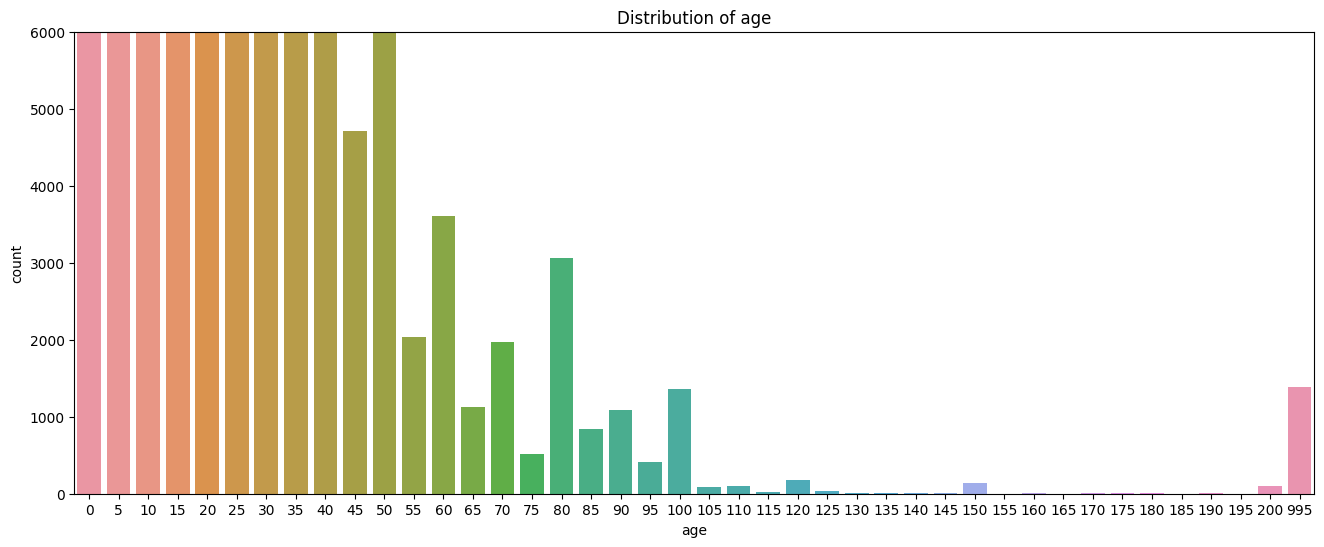

In [9]:
# Plotting the distribution
plt.figure(figsize=(16,6))
sns.countplot(data=train_df, x='age')
plt.title("Distribution of age")
# set the x and y limits
plt.ylim(0, 6000)
plt.savefig('../reports/figures/age_distribution.svg')
plt.show()

### Analysing the categorical features
With regard to the outlier detection of categorical features we are looking for features that are rare or occur with an unusually low frequency. To find outliers we conduct a frequency analysis. With this analysis a percentage threshold is set. All values that occur less times than the threshold are marked as outliers.

The analysis with a threshold of 2% shows that the following features have no outliers:
* 'land_surface_condition'
* 'roof_type' 
* 'other_floor_type'

In [10]:
threshold = 0.02 # the threshold percentage after which values are marked as outliers
cat_outliers = build_features.find_outliers_by_threshold(train_df[categorical_columns], threshold, True)

Start: filtering out outliers with threshold 0.98
Features that have no outliers are: ['land_surface_condition', 'roof_type', 'other_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel']
Features with outliers:
Outliers for feature: geo_level_1_id
    0: 24
    1: 23
    2: 2
    3: 29
    4: 19
    5: 28
Outliers for feature: geo_level_2_id
    0: 465
    1: 1167
    2: 1143
    3: 764
    4: 1223
    5: 425
    6: 386
    7: 467
    8: 993
    9: 822
.. 380 more outliers were found
Outliers for feature: geo_level_3_id
    0: 9738
    1: 3750
    2: 4197
    3: 6355
    4: 1283
    5: 2365
    6: 2108
    7: 8982
    8: 7605
    9: 1288
.. 2541 more outliers were foun

In [11]:
data = train_df.has_secondary_use_agriculture.value_counts()
overall = data[0] + data[1]
print(data)
print(f'Percentage1 {data[0]/overall * 100}')
print(f'Percentage1 {data[1]/overall * 100}')

has_secondary_use_agriculture
0    243824
1     16777
Name: count, dtype: int64
Percentage1 93.56218894018058
Percentage1 6.437811059819418


-------------

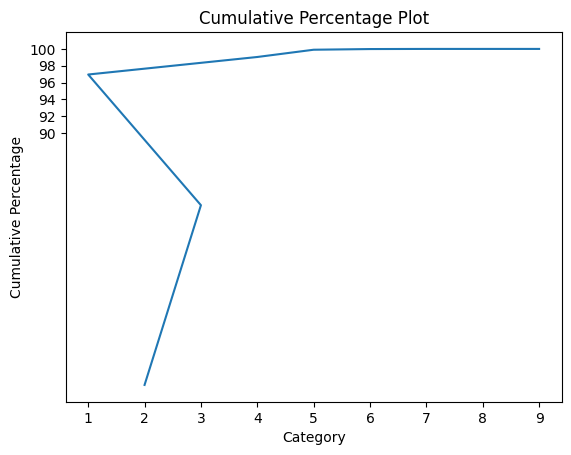

In [12]:
cumulative_sum = train_df['count_floors_pre_eq'].value_counts().sort_values(ascending=False).cumsum()

cumulative_percentage = 100 * cumulative_sum / cumulative_sum.max()

# plot the cumulative percentage
plt.plot(cumulative_percentage.index, cumulative_percentage)

# set the plot title and axis labels
plt.title('Cumulative Percentage Plot')
plt.xlabel('Category')
plt.ylabel('Cumulative Percentage')
yticks = np.arange(90, 102,2)
ylabels = [f"{y:.0f}%" for y in yticks]
plt.yticks(yticks)
# show the plot
plt.show()